C:\Users\Olivér Hiri\AppData\Local\Temp\ipykernel_9028\2347591358.py:49: RuntimeWarning: invalid value encountered in scalar divide
  self.acceleration[k] += grav_const*planets[i].mass*(difference[k][0])*1/(pow(square_distance[0], 3/2))


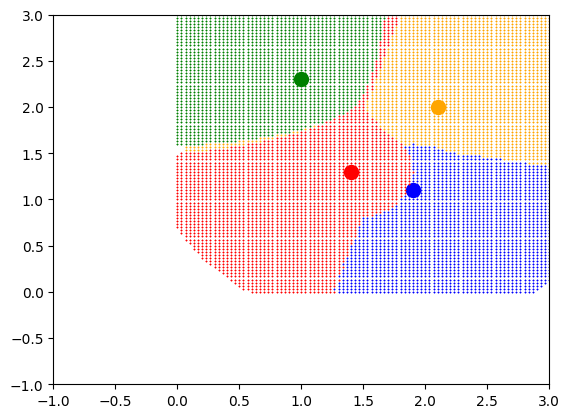

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import multiprocessing
import sys


class Particle:
    """
    Represents a point mass with position, velocity, and acceleration vectors.
    """
    def __init__(self, position=None, velocity=None, acceleration=None, dim=2, mass=1):
        self.dim = dim
        self.mass = mass

        vector_attributes = {
            "position": position,
            "velocity": velocity,
            "acceleration": acceleration,
        }

        #This is so that it can have arbitrary dimension, but also default zero values
        for attr_name, attr_value in vector_attributes.items():
            if attr_value is None:
                setattr(self, attr_name, np.zeros(self.dim))
            else:
                setattr(self, attr_name, attr_value)

            current_vector = getattr(self, attr_name)
            if len(current_vector) != self.dim:
                 raise ValueError(
                    f"{attr_name} vector length ({len(current_vector)}) must match dimension ({self.dim})."
                )
            
    #guide for printing itself
    def __repr__(self):
        return (
            f"Particle(dim={self.dim}, mass={self.mass})\n"
            f"  Pos: {self.position}\n"
            f"  Vel: {self.velocity}\n"
            f"  Acc: {self.acceleration}"
        )
    
    #Updates the acceleration using the positions of the sources of gravitation using Newton's second law and his law for gravitation
    def update_acceleration(self, planets):
        for i in range(len(planets)):
            square_distance = 0
            difference = np.zeros(shape = (self.dim,1))
            for j in range(self.dim):
                difference[j] = planets[i].position[j] - self.position[j]
                square_distance += difference[j]**2
            for k in range(self.dim):
                self.acceleration[k] += grav_const*planets[i].mass*(difference[k][0])*1/(pow(square_distance[0], 3/2))
    
    def check_for_collision(self, planets):
        for i in range(len(planets)):
            square_distance = 0
            difference = np.zeros(shape = (self.dim,1))
            for j in range(self.dim):
                difference[j] = planets[i].position[j] - self.position[j]
                square_distance += difference[j]**2
            if(planets[i].radius**2 >= square_distance):
                return i
        return -1
                                

#Same as particle, but has radius attribute
class Planet(Particle):
    def __init__(self, position=None, velocity=None, acceleration=None, dim=2, mass=1, radius=5*10e-2):
        super().__init__(position=position, velocity=velocity, acceleration=acceleration, dim=dim, mass=mass)
        self.radius = radius

    #guide for printing itself
    def __repr__(self):
        return (
            f"Planet(dim={self.dim}, mass={self.mass}, radius={self.radius})\n"
            f"  Pos: {self.position}\n"
            f"  Vel: {self.velocity}\n"
            f"  Acc: {self.acceleration}"
        )

#The way it's implemented here, it advances the time for a passed particle with dt
def velocity_verlet(particle, planets, dt):
    particle.update_acceleration(planets)
    for i in range(particle.dim):
        particle.position[i] += particle.velocity[i]*dt + 0.5*particle.acceleration[i]*dt**2
        particle.velocity[i] += 0.5*particle.acceleration[i]*dt**2
    particle.update_acceleration(planets)
    for i in range(particle.dim):
        particle.velocity[i] += 0.5*particle.acceleration[i]*dt**2


#This is the main part of the code
#Simulation constants
grav_const = 1
dim = 2
dt = 10e-3  
iter = 100  
planets = [Planet([1.4,1.3]), Planet([1,2.3]), Planet([1.9,1.1]), Planet([2.1,2])]
planet_number = len(planets)
myparticle = Particle()



# --- Trajectory mode - Traces out the trajectory of a particle. Currently only for dim = 2 (!) ---
trajectory_mode = False
if trajectory_mode:
    #Plotting planets
    for i in range(planet_number):
        plt.scatter(planets[i].position[0], planets[i].position[1], c = 'red', s = 100)

    #Plotting particle
    trajectory = np.zeros(shape=(iter, dim))
    for i in range(iter):
        trajectory[i] = myparticle.position
        velocity_verlet(myparticle, planets, dt)
    for i in range(iter):
        plt.scatter(trajectory[i][0], trajectory[i][1], c= 'green', s=1)



# --- Convergence map mode - Colors R^dim according to which planet the particle crashes into first. Currently only for dim = 2 (!) ---
convergence_map_mode = True
if convergence_map_mode:
    #This isn't very elegant but I'm having trouble with the plotting part
    color_list = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    #Plotting planets
    for i in range(planet_number):
        plt.scatter(planets[i].position[0], planets[i].position[1], c = color_list[i], s = 100)
    
    bounds = [[0,5], [0,5]]
    samples_per_row = 150
    samples_per_column = 150
    for i in range(samples_per_column):
        for j in range(samples_per_row):
            myparticle = Particle()
            myparticle.position = [(bounds[0][1]-bounds[0][0])*(1/samples_per_row)*i,(bounds[1][1]-bounds[1][0])*(1/samples_per_column)*j]
            starting_position = np.copy(myparticle.position)
            coll = -1
            for k in range(iter):
                velocity_verlet(myparticle, planets, dt)
                coll = myparticle.check_for_collision(planets)
                if(coll > -1):
                    plt.scatter(starting_position[0], starting_position[1], c = color_list[coll], marker = '*', s =0.1)
                    break

plt.xlim(-1,3)
plt.ylim(-1,3)
plt.show()


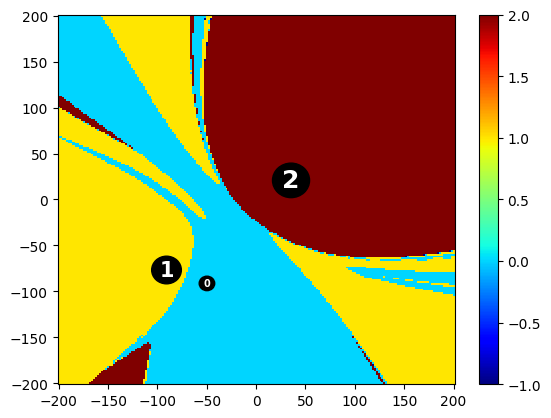

Execution time: 1298.7411 seconds


'\n\ncolor ,trackin= euler_methodfast(G , dt , iter ,drag ,dimension ,planets_symmetric ,x,y,z)\n\ncolor = np.transpose(color)\n\nplotting(dimension , x, y ,z ,color , planets_symmetric ,trackin)\n'

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import time
import multiprocessing
import sys
import matplotlib.animation as anim

def plotting(dim , x, y , z ,colors , planets ,tracking_matrix=0 ,tracking=False , animation=False):

    

    if(dim==2):
        X, Y = np.meshgrid(x, y)
        fig, ax = plt.subplots()
        mesh = ax.pcolormesh(X, Y, colors, cmap='jet')
        plt.colorbar(mesh)


        for i in range(planets.shape[0]):    # for the number of planets we darw a circle
            circle = plt.Circle((planets[i,0], planets[i,1]), planets[i,2], color='black', fill=True)
            ax.add_patch(circle)

            size = int(planets[i,2])
            ax.text(planets[i, 0], planets[i, 1], str(i), 
                   color='white', 
                   ha='center', 
                   va='center',
                   fontsize=size,
                   fontweight='bold',
                   alpha=1 )
            
        if tracking==True:
            #Plotting trajectories
            #Number of tracked probes
            num_tracked = tracking_matrix.shape[2]
            #Looping over stored trajectories (See below for the anatomy of the tracking_matrix)
            for p in range(num_tracked):
                ax.scatter(tracking_matrix[:, 0, p], 
                tracking_matrix[:, 1, p], 
                s=2, alpha=0.6)
                
        if animation == True:
           True

        
        plt.show()

    else:
        X, Y , Z = np.meshgrid(x, y , z)
        plt.pcolormesh(X, Y, colors, cmap='jet')
        plt.colorbar()
        plt.show()


def planet_generation(dim , max_radius,mass ,number, x, y , z):
        #creates a matrix 
        #one row is one planet 
        #first position x then y then z
        # then the radius of the planet
        #then the mass of the planet
        planets = np.zeros((number , dim+2))
        planets[: , 0] = np.random.uniform(-x/2 , x/2 ,number)
        planets[: , 1] = np.random.uniform(-y/2 , y/2 ,number)
        if(dim ==3):
            planets[: , 2] = np.random.uniform(-z/2 , z/2 ,number)
            planets[: , 3] = np.random.uniform(max_radius/4 , max_radius ,number)
            planets[: , 4] = np.random.uniform(0, mass ,number)
        else:
            planets[: , 2] = np.random.uniform(max_radius/4 , max_radius ,number)
            planets[: , 3] = np.random.uniform(0 , mass ,number)


        return planets

#at the moment only 2d euler method
def euler_methodslow(dim ,  planets  , x,y,z):

    G = 1
    dt = 0.05
    iter = 3000
    drag = 0.01

    
    
    particle_trajectory = []

    probe_position = np.array([[xi, yi] for xi in x for yi in y])

    n_planets = len(planets)

    #easier to work with This is the 2d implementation
    planet_positions = planets[:, 0:2]  # x, y columns
    planet_radii = planets[:, 2]        # radius column
    planet_masses = planets[:, 3]       # mass column

    color = np.full(len(probe_position), -1, dtype=int)
    

    for point in range(len(probe_position)):

        probe_p = probe_position[point].copy()
        colission = False
        probe_v = np.array([0.0, 0.0])

        for i in range(iter):

            #we dont need the whole path of the probe 

            gravitational_force= np.zeros(2)
            
            for p in range(len(planets)):
                #distance between planet and probe
                d = planet_positions[p]-probe_p

                #length of the d
                r = np.linalg.norm(d)

                #collision check
                if r < planet_radii[p]:
                    color[point] = p
                    colission = True
                    break

                #gravity
                force_magnitude = G*planet_masses[p] / r**2
                direction = d/r
                gravitational_force += force_magnitude*direction
            if colission==True:
                break
            drag_force = -drag * probe_v
            gravitational_force += drag_force

            probe_v += gravitational_force * dt
            probe_p += probe_v * dt

    
    c = color.reshape(len(y) , len(x))
    return c


def euler_methodfast(G ,dt ,iter , drag , dim ,  planets  , x,y,z):

    particle_trajectory = []

    probe_position = np.array([[xi, yi] for xi in x for yi in y])

    n_planets = len(planets)
    nprobe= len(probe_position)


    #easier to work with This is the 2d implementation
    if dim ==2:
        planet_positions = planets[:, 0:2]  # x, y columns
        planet_radii = planets[:, 2]        # radius column
        planet_masses = planets[:, 3]       # mass column
    else:
        planet_positions = planets[:, 0:3]  # x,y,z columns
        planet_radii = planets[:, 3]        # radius column
        planet_masses = planets[:, 4]       # mass column

    color = np.full(nprobe, -1, dtype=int)
    

    probe_p = probe_position.copy()

    colission = np.ones(nprobe , dtype=bool)
    probe_v = np.zeros((nprobe , dim))


    #Tracking certain particles for trajectories
    number_of_tracked_probes = 7

    #Array that stores the index of the probes to be tracked
    probe_tracked_index = np.random.randint(0, nprobe, number_of_tracked_probes)
    probe_tracked_index = ([138,139,140,141,142,143,144])
    
    #This matrix will store in it's columns the two coordinates of a tracked 
    #probe, the time evolution of those below, and other particles similarly 
    #on the third axis
    tracking_matrix = np.zeros((iter, dim, number_of_tracked_probes))


    for i in range(iter):
        #if there are no more active True values it breaks
        #not flips the boolean
        if not colission.any():
            break
        #we dont need the whole path of the probe 

        gravitational_force= np.zeros((nprobe ,dim))
        
        for p in range(n_planets):
            #distance between planet and probe
            d = planet_positions[p]-probe_p

            #length of the d
            r = np.linalg.norm(d , axis=1)

            #collision check  
            collision_mask = (r < planet_radii[p]) & colission
            color[collision_mask] = p
            colission[collision_mask] = False


            #gravity
            force_magnitude = G*planet_masses[p] / r**2

            
            direction = d/r[ : , np.newaxis]
            
            gravitational_force += (force_magnitude[: , np.newaxis]*direction)

        drag_force = -drag * probe_v
        gravitational_force += drag_force

        probe_v[colission] += gravitational_force[colission] * dt
        probe_p[colission] += probe_v[colission] * dt

        current_positions = probe_p[probe_tracked_index].copy()

        #We don't update the position history of probes that already collided
        #  ~ flips boolean only with arrays
        dead_tracked_mask = ~colission[probe_tracked_index]
        #the ones that hit the planet have value True in dead mask
        current_positions[dead_tracked_mask] = np.nan
        #np.nan erases the postion 

        #Storing the position for later
        tracking_matrix[i, :, :] = current_positions.T

    c = color.reshape(len(y) , len(x))
    return c ,tracking_matrix

def compute_acceleration(positions, velocities, active_mask, color, G, drag, dim, planet_positions, planet_radii, planet_masses):
    
    nprobe = len(positions)
    n_planets = len(planet_positions)
    gravitational_force = np.zeros((nprobe, dim))
    
    for p in range(n_planets):
        # distance between planet and probe
        d = planet_positions[p] - positions
        
        # length of the d
        r = np.linalg.norm(d, axis=1)
        
        # collision check  
        collision_mask = (r < planet_radii[p]) & active_mask
        color[collision_mask] = p
        active_mask[collision_mask] = False
        
        # gravity
        force_magnitude = G * planet_masses[p] / r**2
        
        direction = d / r[:, np.newaxis]
        
        gravitational_force += (force_magnitude[:, np.newaxis] * direction)
    
    # Add drag force
    drag_force = -drag * velocities
    total_acceleration = gravitational_force + drag_force
    
    return total_acceleration, active_mask

def velocity_verlet(G ,dt ,iter , drag , dim ,  planets  , x,y,z):

    particle_trajectory = []

    probe_position = np.array([[xi, yi] for xi in x for yi in y])

    n_planets = len(planets)
    nprobe= len(probe_position)


    #easier to work with This is the 2d implementation
    if dim ==2:
        planet_positions = planets[:, 0:2]  # x, y columns
        planet_radii = planets[:, 2]        # radius column
        planet_masses = planets[:, 3]       # mass column
    else:
        planet_positions = planets[:, 0:3]  # x,y,z columns
        planet_radii = planets[:, 3]        # radius column
        planet_masses = planets[:, 4]       # mass column

    color = np.full(nprobe, -1, dtype=int)
    

    probe_p = probe_position.copy()

    colission = np.ones(nprobe , dtype=bool)
    probe_v = np.zeros((nprobe , dim))

    probe_a, colission = compute_acceleration(probe_p, probe_v, colission, color, 
                                              G, drag, dim, planet_positions, 
                                              planet_radii, planet_masses)

    for i in range(iter):
        if not colission.any():
            break
        

        probe_p[colission] += probe_v[colission] * dt + 0.5 * probe_a[colission] * dt**2
        
        # Compute new acceleration at new position
        probe_a_new, colission = compute_acceleration(probe_p, probe_v, colission, color,
                                                      G, drag, dim, planet_positions,
                                                      planet_radii, planet_masses)
        
        probe_v[colission] += 0.5 * (probe_a[colission] + probe_a_new[colission]) * dt
        
        # Update acceleration for next iteration
        probe_a = probe_a_new


    c = color.reshape(len(y) , len(x))
    return c
# main part of the code


x_points , y_points , z_points= 200,200,10
space = 200
x = np.linspace(-space, space, x_points+1)
y = np.linspace(-space, space, y_points+1)
z = np.linspace(-space, space, z_points+1)


dimension = 2
maxradius = 20
maxmass= 6000
number_of_planets=3

G = 1
dt = 0.05
iter = 6000
drag = 0.005



planets = np.zeros((number_of_planets , dimension+2))

planets_symmetric = np.array([[-50 ,-50/np.sqrt(3) , 10 ,6000] 
                            , [50 , -50/np.sqrt(3) , 10 ,6000],
                              [0 ,   100/np.sqrt(3) , 10 ,6000]])


np.random.seed(41)
planets = planet_generation(dimension , maxradius,maxmass,number_of_planets ,space,space,space)




start = time.time()
color= euler_methodslow(dimension ,planets ,x,y,z)

color = np.transpose(color)

plotting(dimension , x, y ,z ,color , planets)
end = time.time()

print(f"Execution time: {end - start:.4f} seconds")

"""
np.random.seed(48)
start2 = time.time()
color2 ,tracking_matrix= euler_methodfast(G , dt , iter ,drag ,dimension ,planets ,x,y,z )

color2 = np.transpose(color2)

plotting(dimension , x, y ,z ,color2 , planets ,tracking_matrix , False )
plotting(dimension , x, y ,z ,color2 , planets ,tracking_matrix , True )

end2 = time.time()
print(f"Execution time: {end2 - start2:.4f} seconds")

"""
"""

color ,trackin= euler_methodfast(G , dt , iter ,drag ,dimension ,planets_symmetric ,x,y,z)

color = np.transpose(color)

plotting(dimension , x, y ,z ,color , planets_symmetric ,trackin)
"""
